# EXERCISE SHEET 2
## 1 Uniform Manifold Approximation and Projection

(a) Vibe-code this simplified version of UMAP. Try not to code a single line! You can use the GitHub
Copilot agent inside your IDE (e.g., using the integration in VS Code) instead of asking a chatbot
like ChatGPT. Let the agent implement the following steps:
- Load data
- Build symmetrized kNN graph
- Extract edges
- Do force directed layout from random initialization using gradient descent with a decreasing
learning rate. Use analytical derivatives which are hard-coded, not automated differentiation.
Resample the pairs in the repulsive term in each iteration.

Read “your” code and try and understand it line by line. Verify its mathematical correctness.

(b) Apply UMAP to the jet data from the first sheet. Compare these results with those obtained using
PCA.

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import _utils
from sklearn.utils import check_random_state
from sklearn.decomposition import PCA

import scipy.sparse as sp

In [31]:
# Define the relative path to the data directory
data_path = "../sheet01/data/"

# Load numpy files
# Data matrix (n_samples x n_features)
dj_feats_norm = np.load(os.path.join(data_path, "dijet_features_normalized.npy"))
# Corresponding labels (n_samples,)
dj_labels = np.load(os.path.join(data_path, "dijet_labels.npy"))

In [39]:
dj_labels


array([2., 2., 2., ..., 0., 2., 2.], shape=(2233,))

In [32]:
# Build symmetrised kNN graph
# 10 neighbors, distance mode (Euclidean), no self-loops (points are not connected to themselves)
knn_graph = kneighbors_graph( # computes sparse matrix representing which samples are nearest neighbours
    dj_feats_norm, n_neighbors=10, mode="distance", include_self=False
)

# Extract edges
# Return the upper triangular part of the sparse matrix (to avoid duplicate edges in undirected graph, since i<-->j = j<-->i)
edges = np.array(sp.triu(knn_graph).nonzero()).T

# The edges are a list of all connections between points in the graph
print(f"Number of edges in the kNN graph: {edges.shape[0]}")

Number of edges in the kNN graph: 482


In [ ]:
def compute_force_directed_layout_grad(X, edges, n_samples, repulsion_scale=1.0, 
                                       n_repulsive_samples=50, random_state=None):
    """
    Compute gradient for simplified UMAP force-directed layout using explicit potentials.
    
    Parameters:
    -----------
    X : array of shape (n_samples, 2)
        Current embedding
    edges : array of shape (n_edges, 2)
        Edges from kNN graph
    n_samples : int
        Number of samples
    repulsion_scale : float
        Scale of repulsive forces (c)
    n_repulsive_samples : int
        Number of repulsive samples per iteration
    random_state : RandomState
        Random number generator
    """
    grad = np.zeros_like(X)
    
    # Attractive forces from edges (Phi_attr(d^2) = log(1 + d^2))
    for i, j in edges:
        diff = X[i] - X[j]
        d2 = np.sum(diff**2)
        if d2 > 0:
            grad_attr = 2 * diff / (1 + d2)
            grad[i] += grad_attr
            grad[j] -= grad_attr
    
    # Repulsive forces from random pairs (Phi_rep(d^2) = c / (1 + d^2))
    rng = np.random.RandomState(random_state.randint(0, 2**31-1))
    for _ in range(n_repulsive_samples):
        i, j = rng.choice(n_samples, size=2, replace=False)
        diff = X[i] - X[j]
        d2 = np.sum(diff**2)
        if d2 > 0:
            grad_rep = -2 * repulsion_scale * diff / (1 + d2)**2
            grad[i] += grad_rep
            grad[j] -= grad_rep
    
    return grad


# Initialize random 2D embedding
random_state = check_random_state(0)  # Set random seed for reproducibility
n_samples = dj_feats_norm.shape[0]    # Get number of data points
X = 0.1 * random_state.randn(n_samples, 2)  # Initialize random 2D embedding

# Optimisation parameters
n_iter = 1000        # Number of optimization iterations
initial_lr = 100.0   # Initial learning rate

# Gradient descent loop (points get pulled to their neighbors and pushed away from random other points)
for i in range(n_iter):
    
    lr = initial_lr * (1.0 - i / n_iter) # Decreasing learning rate
    # Compute gradient
    grad = compute_force_directed_layout_grad(
        X,                         # Current embedding
        edges,                     # Edges from kNN graph
        n_samples,                 # Number of data points
        repulsion_scale=1.0,       # Repulsion scale
        n_repulsive_samples=50,    # Number of repulsive samples
        random_state=random_state, # Random state for sampling
    )
    
    # Update embedding
    X -= lr * grad


dj_feats_norm shape: (116, 2233)
dj_labels shape: (2233,)
Sample labels shape: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]


/tmp/ipykernel_7758/829149814.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', len(classes))


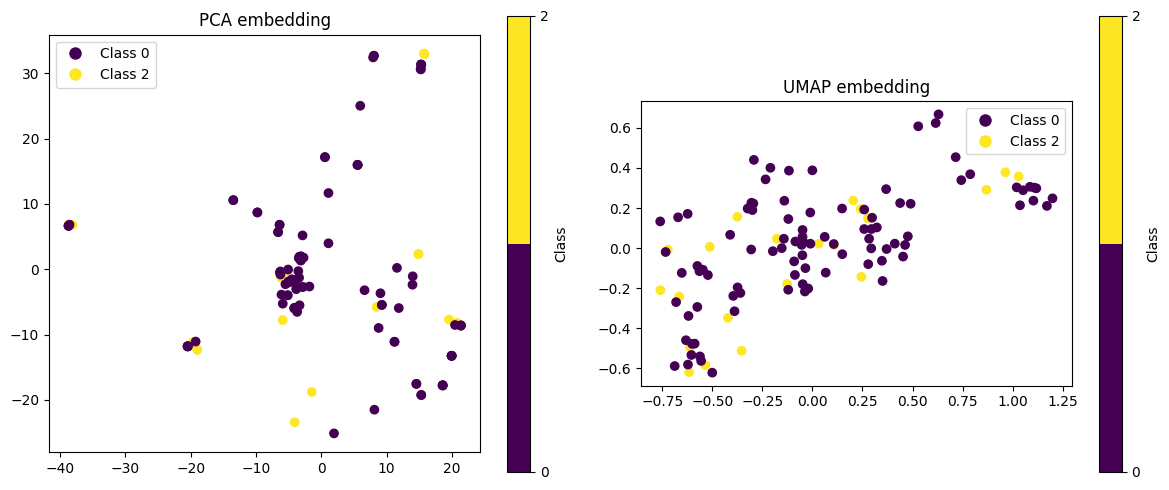

In [41]:
# Print shapes to verify
print("dj_feats_norm shape:", dj_feats_norm.shape)  # (116, 2233)
print("dj_labels shape:", dj_labels.shape)          # (2233,)

from scipy.stats import mode

# sample_labels: mode of labels across all features (axis=0)
sample_labels = mode(dj_labels, keepdims=False).mode
# if dj_labels shape is (2233,), sample_labels will be a scalar
# probably you want per-sample labels; if features are aligned to samples:
sample_labels = dj_labels[:dj_feats_norm.shape[0]].astype(int)  # simplest mapping


print("Sample labels shape:", sample_labels)  # (116,)

# Filter out any "empty" samples if present
valid_idx = sample_labels >= 0
X_features = dj_feats_norm[valid_idx]
sample_labels = sample_labels[valid_idx]

# Create discrete colormap for classes
classes = np.unique(sample_labels)
cmap = plt.cm.get_cmap('viridis', len(classes))

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# PCA embedding
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_features)
scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=sample_labels, cmap=cmap)
ax1.set_title("PCA embedding")
cbar1 = fig.colorbar(scatter1, ax=ax1, ticks=classes)
cbar1.set_label('Class')
cbar1.set_ticklabels([str(int(c)) for c in classes])

# UMAP embedding (assume X is your force-directed / UMAP result)
X_umap_valid = X[valid_idx]  # keep same indices
scatter2 = ax2.scatter(X_umap_valid[:, 0], X_umap_valid[:, 1], c=sample_labels, cmap=cmap)
ax2.set_title("UMAP embedding")
cbar2 = fig.colorbar(scatter2, ax=ax2, ticks=classes)
cbar2.set_label('Class')
cbar2.set_ticklabels([str(int(c)) for c in classes])

# Set same scale for both plots
ax1.set_aspect('equal')
ax2.set_aspect('equal')

# Add legend for unique classes
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=cmap(i), label=f'Class {int(i)}', markersize=10)
    for i in classes
]
ax1.legend(handles=legend_elements, loc='best')
ax2.legend(handles=legend_elements, loc='best')

plt.tight_layout()
plt.show()


## 2 Kernel Density Estimation